# Segmentation of bone

In [1]:
# import needed libraries
import numpy as np
import pandas as pd
import nibabel as nib
import os
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_fill_holes,binary_dilation, binary_propagation, distance_transform_edt
from scipy.ndimage import generate_binary_structure, iterate_structure, zoom, binary_closing, binary_erosion
from scipy.ndimage import center_of_mass
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
import imageio
from IPython.display import Image
from io import BytesIO

In [3]:
# load image file

data_dir = '../Data/'
file_name = '3702_left_knee.nii.gz'

# function to load image
def load_nii_img(data_dir, file_name):
    data_path = data_dir
    file_path = os.path.join(data_path,file_name )
    img = nib.load(file_path)
    return img

In [4]:
# call load nii_image function
ni_img = load_nii_img(data_dir, file_name)

In [5]:
#get numpy array of image
data = ni_img.get_fdata()  

In [6]:
data.shape

(512, 512, 216)

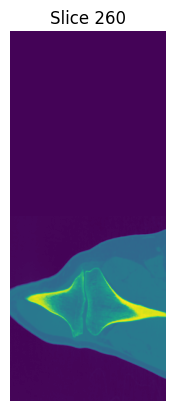

In [12]:
# coronal view of bone
slice_idx = 260 # middle slice of image
plt.imshow(data[:, slice_idx, :])
plt.axis('off')
plt.title(f'Slice {slice_idx}')
plt.show()

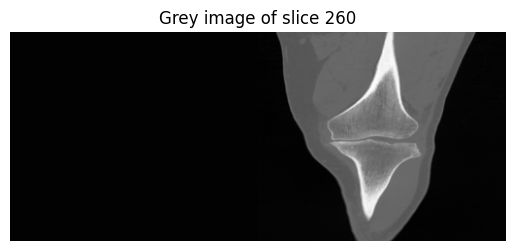

In [17]:
# grey image of coronal view of bone
title1 = 'Grey image of slice 260'
def view_slice_img(data,title):
    plt.imshow(data[:, 260,:].T, origin='lower', cmap = 'grey')  #plot middle slice of image
    plt.title(title)   # image title
    plt.axis('off')    
    plt.show()  

view_slice_img(data, title1)

In [18]:
"""
class to perform:

Thresholding.

Label the connected components to isolate femur and tibia.

Apply morphological operations (dilation and closing).

Fill holes in slices.

Normalize the volume.

Color-code the segmented bones.

Return the segmented bone volume and allow visualization
"""
class BoneSegmentationPipeline:
    def __init__(self, threshold=350, dilation_kernel=(5,5,5)):
        self.threshold = threshold
        self.dilation_kernel = dilation_kernel
        self.tibia_label = None
        self.femur_label = None

    def threshold_bone(self, data):
        return (data >= self.threshold).astype(np.uint8)

    def label_components(self, bone_mask):
        labeled_mask, num_features = label(bone_mask)
        print(f"Number of components detected: {num_features}")
        component_sizes = np.bincount(labeled_mask.flatten())
        largest_labels = component_sizes[1:].argsort()[-2:] + 1
        print("Tibia and Femur labels:", largest_labels)
        self.tibia_label, self.femur_label = largest_labels
        return labeled_mask

    def create_masks(self, labeled_mask):
        tibia_mask = (labeled_mask == self.tibia_label).astype(np.uint8)
        femur_mask = (labeled_mask == self.femur_label).astype(np.uint8)
        return tibia_mask, femur_mask

    def dilate_and_fill_masks(self, tibia_mask, femur_mask):
        tibia_dilated = binary_dilation(tibia_mask, structure=np.ones(self.dilation_kernel))
        femur_dilated = binary_dilation(femur_mask, structure=np.ones(self.dilation_kernel))
        femur_dilated = binary_closing(femur_dilated)
        filled_tibia = self.fill_3d_mask_slices(tibia_dilated)
        filled_femur = self.fill_3d_mask_slices(femur_dilated)
        return filled_tibia.astype(bool), filled_femur.astype(bool)

    def fill_3d_mask_slices(self, mask_3d):
        filled_mask = np.zeros_like(mask_3d, dtype=np.uint8)
        for y in range(mask_3d.shape[1]):
            filled_mask[:, y, :] = binary_fill_holes(mask_3d[:, y, :]).astype(np.uint8)
        return filled_mask

    def normalize_data(self, data):
        return ((data - data.min()) / (data.max() - data.min()) * 255).astype(np.uint8)

    def apply_color_segmentation(self, data, tibia_mask, femur_mask):
        norm_data = self.normalize_data(data)
        color_volume = np.stack([norm_data]*3, axis=-1)
        color_volume[femur_mask] = [255, 0, 0]  # Red
        color_volume[tibia_mask] = [0, 255, 0]  # Green
        return color_volume

    def visualize_segmentation(self, color_volume, slice_idx):
        plt.imshow(color_volume[:, slice_idx, :, :].transpose(1, 0, 2), origin='lower')
        plt.title('Femur bone and Tibia bone Segmented')
        plt.axis('off')
        plt.show()

    def run(self, data, slice_idx=None, visualize=True):
        bone_mask = self.threshold_bone(data)
        labeled_mask = self.label_components(bone_mask)
        tibia_mask, femur_mask = self.create_masks(labeled_mask)
        filled_tibia, filled_femur = self.dilate_and_fill_masks(tibia_mask, femur_mask)
        color_volume = self.apply_color_segmentation(data, filled_tibia, filled_femur)
        if visualize and slice_idx is not None:
            self.visualize_segmentation(color_volume, slice_idx)
        return color_volume, filled_tibia, filled_femur


Number of components detected: 526
Tibia and Femur labels: [58 48]


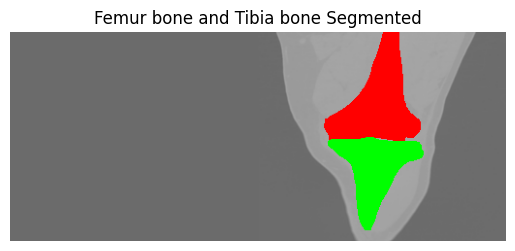

In [19]:
slice_idx = 260  # slice where bone is mostly visible

segmenter = BoneSegmentationPipeline()
color_volume, tibia_mask, femur_mask = segmenter.run(data, slice_idx=slice_idx)

# Convert 2D Pretrained Model to 3D

In [20]:
import torchvision.models as models
model_2d = models.densenet121(pretrained=True)

C:\Users\User\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\User/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:02<00:00, 14.5MB/s]


In [21]:
# print model architecture
print(model_2d)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
# print model parameters
total_params = sum(p.numel() for p in model_2d.parameters())
trainable_params = sum(p.numel() for p in model_2d.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 7978856
Trainable parameters: 7978856


In [23]:
data.shape

(512, 512, 216)